In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
import scipy.stats as st
import matplotlib
import pickle
import scipy
from scipy.optimize import curve_fit

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
def get_exp(epochs = 15, N = [200, 50], reg_coeff = 0.0005, reg_type = 'continuous', do_print = 'plot'):
    """ Train and return the result """
    def get_p_arr(p):
        """ p array with failure on the first layer """
        return [0, p]  + [0] * len(N)

    # Lips. coeff
    KLips = 1.

    # activation function
    activation = 'sigmoid'

    # training the network
    exp = MNISTExperiment(N = N, p_inference = get_p_arr(0), p_train = get_p_arr(0),
                          KLips = KLips, epochs = epochs,
                          activation = activation, reg_type = reg_type,
                          reg_coeff = reg_coeff, do_print = do_print,
                          name = 'experiment_weights', seed = None, batch_size = 1000)
    
    # returning the weights in the middle
    return exp

In [3]:
# dimensions to try
Ns = [int(t) for t in np.linspace(50, 1500, 15)]

# how much repetitions for each experiment are needed?
repetitions = 3

print('Sizes', Ns)
print('Repetitions', repetitions)
print('Total runs', len(Ns) * repetitions)

Sizes [50, 153, 257, 360, 464, 567, 671, 775, 878, 982, 1085, 1189, 1292, 1396, 1500]
Repetitions 3
Total runs 45


In [4]:
# parameters for each experiment
parameters = {'reg_coeff': 0, 'reg_type': None, 'do_print': 'plot', 'epochs': 15}

In [5]:
def parameters_for_N(N):
    """ Parameters for get_exp for a particular N """
    param1 = {x: y for x, y in parameters.items()}
    param1['N'] = [N, 100]
    return param1

In [6]:
def experiment_for_N(N):
    """ Experiment with N """
    return get_exp(**parameters_for_N(N))

In [7]:
def mean_dLdy(exp, irange = range(60000)):
    """ Mean derivative w.r.t. the input for the model """
    # obtain the loss
    loss = exp.model_correct.loss(exp.output_tensor, exp.model_correct.output)

    # obtain first layer output
    y1 = exp.model_correct.layers[0].output

    # input tensor
    inp = exp.model_correct.input

    # output tensor with answers
    out = exp.output_tensor

    # gradients w.r.t. first layer output
    dL_dy1 = tf.gradients(loss, y1)[0]

    # some input/output pairs
    x = exp.x_train[irange]
    y = exp.y_train[irange]

    # mean over everything, should decay as 1/n_l
    dL_dy1_abs_mean_B_mean_N = tf.reduce_mean(tf.reduce_mean(tf.abs(dL_dy1), axis = 0))

    sess = get_session()

    return sess.run(dL_dy1_abs_mean_B_mean_N, feed_dict = {inp: x, out: y})

  0%|          | 0/15 [00:00<?, ?it/s]

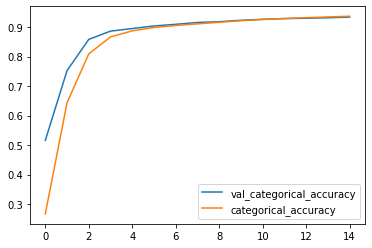

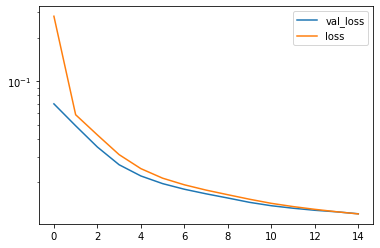

  7%|▋         | 1/15 [00:06<01:24,  6.03s/it]

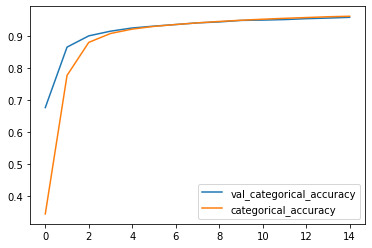

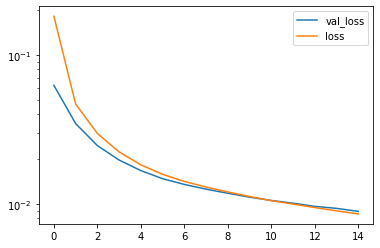

 13%|█▎        | 2/15 [00:12<01:18,  6.01s/it]

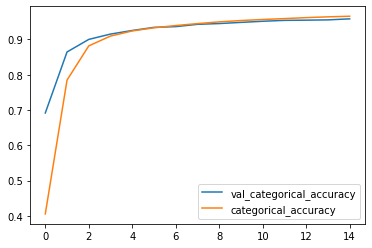

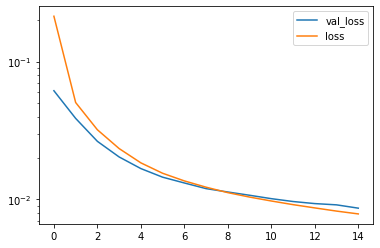

 20%|██        | 3/15 [00:18<01:13,  6.14s/it]

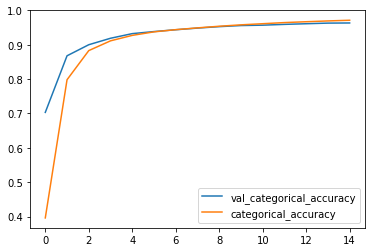

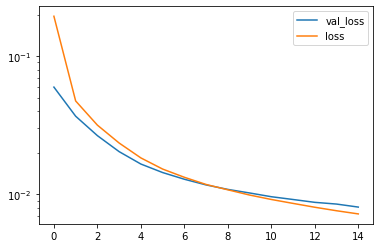

 27%|██▋       | 4/15 [00:25<01:10,  6.40s/it]

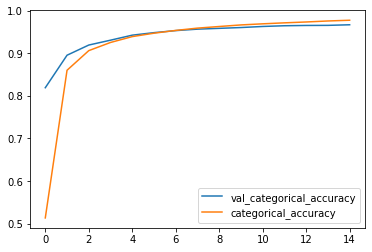

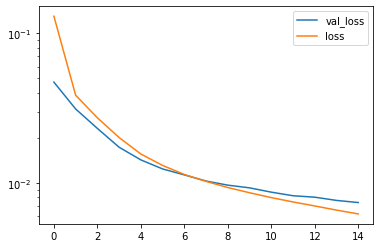

 33%|███▎      | 5/15 [00:32<01:05,  6.55s/it]

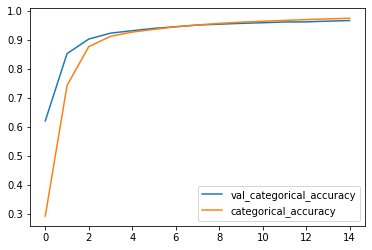

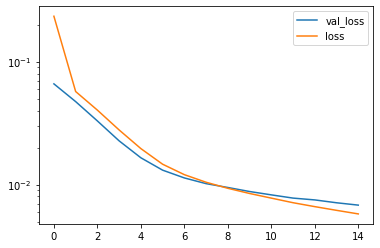

 40%|████      | 6/15 [00:39<01:00,  6.76s/it]

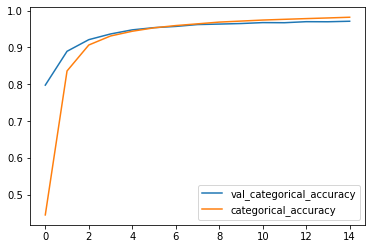

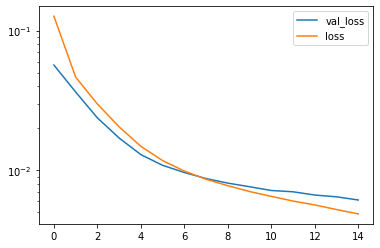

 47%|████▋     | 7/15 [00:47<00:56,  7.05s/it]

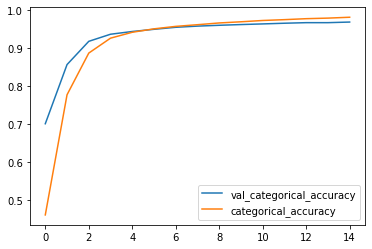

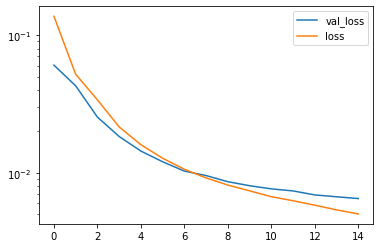

 53%|█████▎    | 8/15 [00:54<00:49,  7.13s/it]

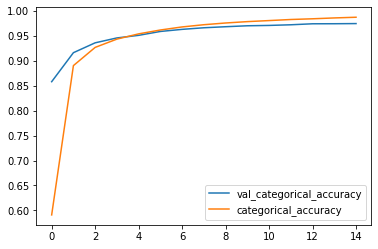

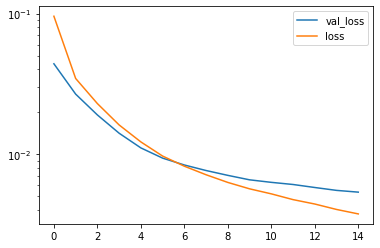

 60%|██████    | 9/15 [01:02<00:43,  7.25s/it]

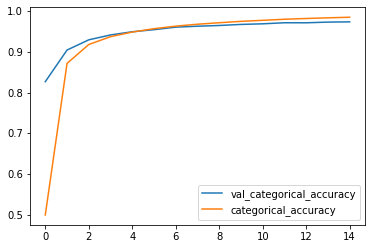

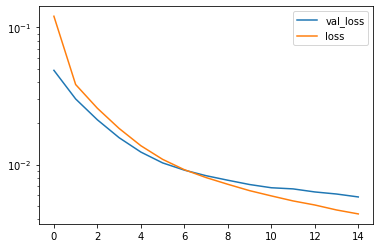

 67%|██████▋   | 10/15 [01:09<00:36,  7.40s/it]

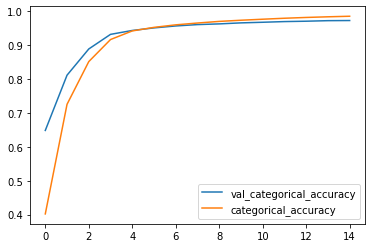

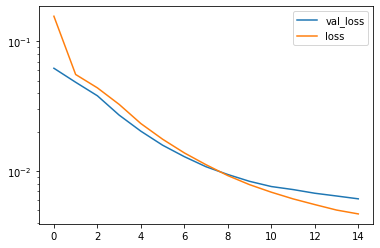

 73%|███████▎  | 11/15 [01:17<00:30,  7.54s/it]

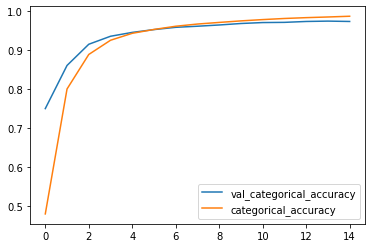

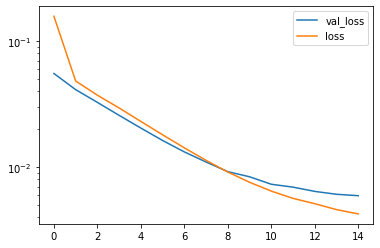

 80%|████████  | 12/15 [01:26<00:23,  7.91s/it]

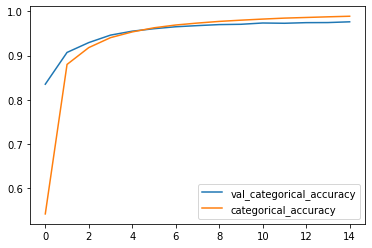

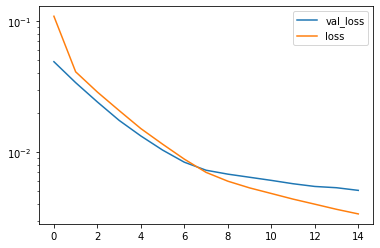

 87%|████████▋ | 13/15 [01:35<00:16,  8.31s/it]

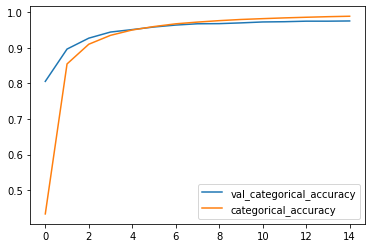

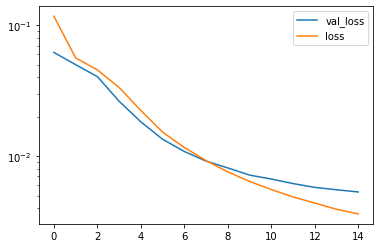

 93%|█████████▎| 14/15 [01:44<00:08,  8.56s/it]

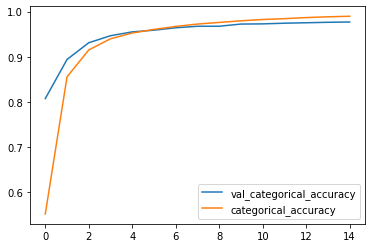

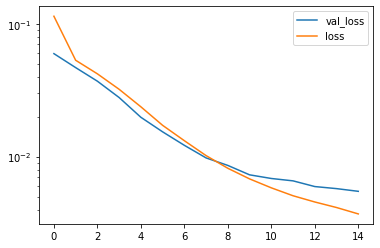

100%|██████████| 15/15 [01:54<00:00,  7.65s/it]


In [8]:
results = []
for N in tqdm(Ns):
    exp = experiment_for_N(N)
    results.append(mean_dLdy(exp))

In [9]:
def line_1_bias(x, C):
    """ Line passing (0,0) """
    return -x + C

In [10]:
# fitting the curve

xs = np.log(Ns)
ys = np.log(results)

C = curve_fit(line_1_bias, xs, ys)[0][0]

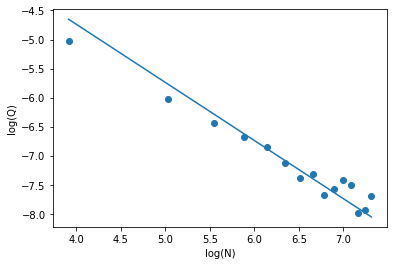

In [11]:
plt.figure()
plt.scatter(xs, ys)
plt.plot(xs, line_1_bias(xs, C))
plt.xlabel('log(N)')
plt.ylabel('log(Q)')
plt.show()